In [1]:
from datetime import datetime
from math import ceil
import requests
import time
import bs4
import sys

# Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import cluster, covariance, manifold

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号

In [3]:
from statsmodels.tsa.stattools import adfuller

In [4]:
import gc

In [5]:
def read_stocks():
    stocks = []
    hushen300_symbols = pd.read_csv('./hushen300_symbols.csv')
    names_zh = hushen300_symbols['Constituent_Name_zh']
    names_en = hushen300_symbols['Constituent_Name_en']

    for name in names_zh:
        stocks.append(pd.read_csv('./hushen300/' + name + '.csv'))
    return stocks,names_zh,names_en

In [6]:
def datelist(beginDate, endDate):
    # beginDate, endDate是形如‘20160601’的字符串或datetime格式
    date_l=[datetime.strftime(x,'%Y-%m-%d') for x in list(pd.date_range(start=beginDate, end=endDate))]
    return date_l

In [7]:
def get_formed_data(start_date='2016-1-4',end_date='2019-12-31'):
    stocks,names_zh,names_en = read_stocks()
    date_list = pd.DataFrame(datelist(start_date,end_date))
    date_list.columns = ['date']
    # 合并所有数据
    print('按日期合并所有数据......')
    for i , stock in enumerate(stocks):
        stocks[i] = date_list.merge(
            stock 
            , how='left'
            , on='date'
            ).set_index(keys=['date'] , drop=True)
    # 填充缺失值
    return stocks,names_zh

In [8]:
stocks,names = get_formed_data()
gc.collect()

按日期合并所有数据......


7

In [9]:
for i , stock in enumerate(stocks):
    # 只保留收盘数据
    stock = stock[['close']]
    # 缺失值填充
    stock.fillna(method='ffill',inplace=True)
    stock.dropna(axis=0,how='all',inplace=True)
    stocks[i] = stock

gc.collect()

0

In [10]:
# adf 检验
adf_res = []
for stock in stocks:
    adf_res.append(adfuller(stock['close']))

# ADF检验

在使用很多时间序列模型的时候，如 ARMA、ARIMA，都会要求时间序列是平稳的，

所以一般在研究一段时间序列的时候，第一步都需要进行平稳性检验，除了用肉眼检测的方法，另外比较常用的严格的统计检验方法就是ADF检验，也叫做单位根检验。

ADF检验全称是 Augmented Dickey-Fuller test，顾名思义，ADF是 Dickey-Fuller检验的增广形式。

DF检验只能应用于一阶情况，当序列存在高阶的滞后相关时，可以使用ADF检验，所以说ADF是对DF检验的扩展。

## 单位根（unit root）

在做ADF检验，也就是单位根检验时，需要先明白一个概念，也就是要检验的对象——单位根。

当一个自回归过程中： ，如果滞后项系数b为1，就称为单位根。

当单位根存在时，自变量和因变量之间的关系具有欺骗性，因为残差序列的任何误差都不会随着样本量（即时期数）增大而衰减，也就是说模型中的残差的影响是永久的。这种回归又称作伪回归。如果单位根存在，这个过程就是一个随机漫步（random walk）。

## ADF检验的原理

ADF检验就是判断序列是否存在单位根：如果序列平稳，就不存在单位根；否则，就会存在单位根。

所以，ADF检验的 **H0 假设就是存在单位根** ，

## 如果得到的显著性检验统计量小于三个置信度（10%，5%，1%），则对应有（90%，95，99%）的把握来拒绝原假设。

adfuller函数的参数意义分别是：

```
x：一维的数据序列。
maxlag：最大滞后数目。
regression：回归中的包含项（c：只有常数项，默认；ct：常数项和趋势项；ctt：常数项，线性二次项；nc：没有常数项和趋势项）
autolag：自动选择滞后数目（AIC：赤池信息准则，默认；BIC：贝叶斯信息准则；t-stat：基于maxlag，从maxlag开始并删除一个滞后直到最后一个滞后长度基于 t-statistic 显著性小于5%为止；None：使用maxlag指定的滞后）
store：True  False，默认。
regresults：True 完整的回归结果将返回。False，默认。
返回值意义为：
```

```
adf：Test statistic，T检验，假设检验值。
pvalue：假设检验结果。
usedlag：使用的滞后阶数。
nobs：用于ADF回归和计算临界值用到的观测值数目。
icbest：如果autolag不是None的话，返回最大的信息准则值。
resstore：将结果合并为一个dummy。
```

In [11]:
adf_res

[(-1.7289461864892035,
  0.4162636061740209,
  0,
  1457,
  {'1%': -3.434846127900848,
   '5%': -2.8635257411342616,
   '10%': -2.5678271914441395},
  -1234.0814125116185),
 (-2.625163118412705,
  0.08790727978137003,
  8,
  1449,
  {'1%': -3.4348709954268384,
   '5%': -2.863536715724964,
   '10%': -2.567833035595811},
  -1338.7618068961547),
 (0.18775663988866037,
  0.9715664801043821,
  24,
  1433,
  {'1%': -3.434921564946909,
   '5%': -2.8635590328954197,
   '10%': -2.567844919904611},
  3531.1445109648307),
 (-1.2286051423719375,
  0.6611710729575131,
  3,
  1454,
  {'1%': -3.4348554210983093,
   '5%': -2.8635298424390276,
   '10%': -2.5678293754552732},
  -5080.330248999244),
 (-2.9386556646510678,
  0.04103400205462035,
  1,
  1456,
  {'1%': -3.43484922137066,
   '5%': -2.8635271063560412,
   '10%': -2.5678279184465946},
  -2738.354874545418),
 (-1.8270383740650238,
  0.36712290042263146,
  0,
  1457,
  {'1%': -3.434846127900848,
   '5%': -2.8635257411342616,
   '10%': -2.5678271

In [12]:
# t > 5% 的话就是随机游走
random_walk = []
for res in adf_res:
    random_walk.append(res[0] > res[4]['5%'])

name_randomwalk = pd.DataFrame({'name':names,'random_walk':random_walk})
name_randomwalk[name_randomwalk['random_walk']==False]

,name,random_walk
4,华能国际,False
16,中直股份,False
33,上海建工,False
35,兖州煤业,False
41,航天信息,False
46,华夏幸福,False
50,中航电子,False
53,金地集团,False
61,烽火通信,False
64,中天科技,False


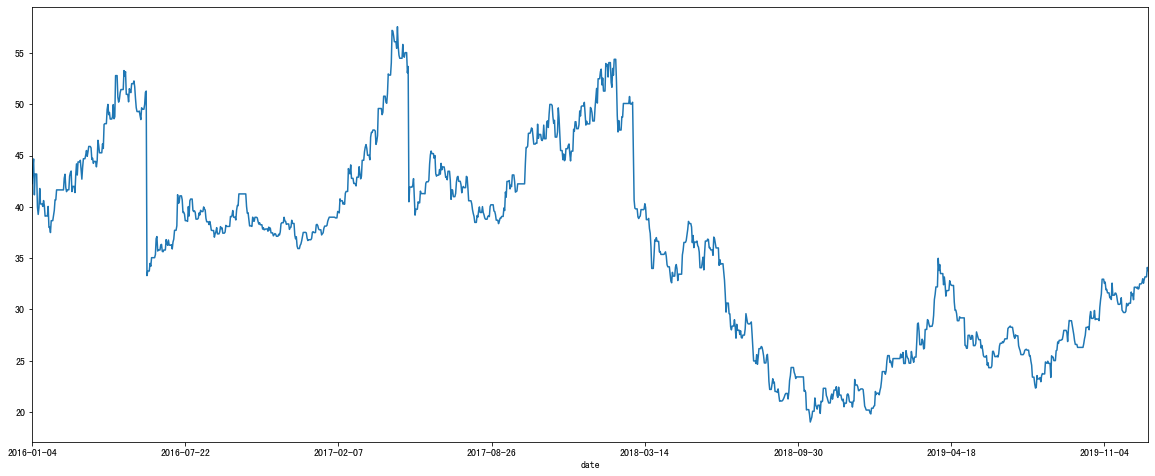

In [30]:
plt.figure(figsize=(20,8))
stocks[268]['close'].plot()
plt.show()

# Hurst 指数

一个具有赫斯特统计特性的系统，不需要通常概率统计学的独立随机事件假设。它反映的是一长串相互联系事件的结果。今天发生的事将影响未来，过去的事也会影响现在。这正是我们分析资本市场所需要的理论和方法。

传统的概率统计学，对此是难办到的 

赫斯特指数有三种形式：

1. 如果H=0.5，表明时间序列可以用随机游走来描述；
2. 如果0.5<H<1，表明时间序列存在长期记忆性；
3. 如果0≤H<0.5，表明粉红噪声(反持续性)即均值回复过程。也就是说，只要H≠0.5，就可以用有偏的布朗运动(分形布朗运动)来描述该时间序列数据。

### 1. H < 0.5  mean reverting
### 2. H = 0.5  Random Walk
### 3. H > 0.5  trending

In [13]:
def hurst(ts):
    ts = list(ts)
    N = len(ts)
    if N < 20:
        raise ValueError("Time series is too short! input series ought to have at least 20 samples!")

    max_k = int(np.floor(N/2))
    R_S_dict = []
    for k in range(10,max_k+1):
        R,S = 0,0
        # split ts into subsets
        subset_list = [ts[i:i+k] for i in range(0,N,k)]
        if np.mod(N,k)>0:
            subset_list.pop()
            #tail = subset_list.pop()
            #subset_list[-1].extend(tail)
        # calc mean of every subset
        mean_list=[np.mean(x) for x in subset_list]
        for i in range(len(subset_list)):
            cumsum_list = pd.Series(subset_list[i]-mean_list[i]).cumsum()
            R += max(cumsum_list)-min(cumsum_list)
            S += np.std(subset_list[i])
        R_S_dict.append({"R":R/len(subset_list),"S":S/len(subset_list),"n":k})
    
    log_R_S = []
    log_n = []
    #print(R_S_dict)
    for i in range(len(R_S_dict)):
        R_S = (R_S_dict[i]["R"]+np.spacing(1)) / (R_S_dict[i]["S"]+np.spacing(1))
        log_R_S.append(np.log(R_S))
        log_n.append(np.log(R_S_dict[i]["n"]))

    Hurst_exponent = np.polyfit(log_n,log_R_S,1)[0]
    return Hurst_exponent

In [14]:
def hurst2(data):
    n = 6
    data = pd.Series(data).pct_change()[1:]
    ARS = list()
    lag = list()
    for i in range(n):
        m = 2 ** i
        size = np.size(data) // m
        lag.append(size)
        panel = {}
        for j in range(m):
            panel[str(j)] = data[j*size:(j+1)*size].values
            
        panel = pd.DataFrame(panel)
        mean = panel.mean()
        Deviation = (panel - mean).cumsum()
        maxi = Deviation.max()
        mini = Deviation.min()
        sigma = panel.std()
        RS = maxi - mini
        RS = RS / sigma
        ARS.append(RS.mean())
        
    lag = np.log10(lag)
    ARS = np.log10(ARS)
    hurst_exponent = np.polyfit(lag, ARS, 1)
    hurst = hurst_exponent[0]
    
    return hurst

In [15]:
hursts = []
# 计算hurst
for i,stock in enumerate(stocks):
    name = names[i]
    h1 = hurst(stock['close'])
    h2 = hurst2(stock['close'])
    hursts.append((name,h1,h2))

In [28]:
names[names == '老板电器']

268    老板电器
Name: Constituent_Name_zh, dtype: object

In [16]:
hursts = pd.DataFrame(hursts)
hursts

,0,1,2
0,浦发银行,1.006836,0.511842
1,首创股份,1.044343,0.509572
2,上海机场,0.998994,0.504283
3,包钢股份,0.971819,0.431736
4,华能国际,0.891901,0.427208
...,...,...,...
295,汇川技术,1.012486,0.480302
296,信维通信,0.975750,0.530535
297,宋城演艺,0.986874,0.474302
298,光线传媒,1.022528,0.466592


In [29]:
hursts.iloc[268]

names        老板电器
h1       0.970193
h2       0.534754
Name: 268, dtype: object

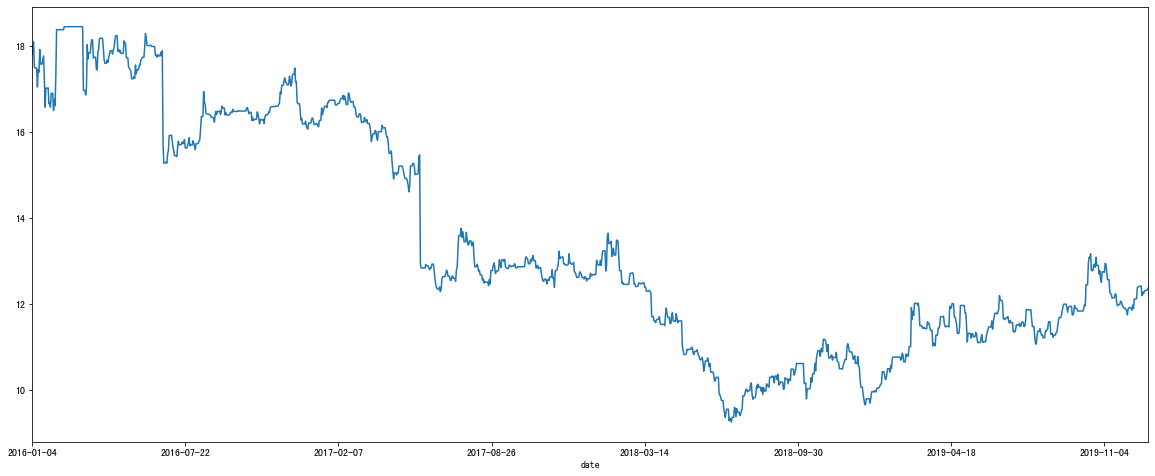

In [21]:
plt.figure(figsize=(20,8))
stocks[0]['close'].plot()
plt.show()

In [23]:
hursts.columns =['names','h1','h2']

In [25]:
hursts[hursts['h2'] < 0.45]

,names,h1,h2
3,包钢股份,0.971819,0.431736
4,华能国际,0.891901,0.427208
16,中直股份,0.929394,0.387094
43,广汇汽车,0.992162,0.406164
50,中航电子,0.917589,0.440755
55,国电南瑞,0.980379,0.393082
61,烽火通信,0.877226,0.416099
64,中天科技,1.017775,0.423397
70,海螺水泥,1.002924,0.440865
83,物产中大,0.990786,0.426759
